In [1]:
#Import libaries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from math import ceil
from scipy.stats import norm, t
from scipy import stats

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [2]:
#Select stock tickers
ticker_symbols = ["SHEL", "BHP", "BA", "T", "KO", "JNJ", "JPM", "SAP", "TJX", "NEE", "PLD"]

#Get historic daily stock returns
starts = '2014-03-30'
ends = '2024-03-30'
stock_data = yf.download(ticker_symbols, starts, ends)['Adj Close']
returns = stock_data.pct_change()
returns.dropna(inplace=True)


[*********************100%%**********************]  11 of 11 completed


In [3]:
returns.head()

Ticker,BA,BHP,JNJ,JPM,KO,NEE,PLD,SAP,SHEL,T,TJX
Date,,,,,,,,,,,
2014-04-01,0.021675,0.020511,-0.002952,-0.000659,-0.006467,-0.007948,0.001224,0.005657,0.002327,0.000570,0.008904
2014-04-02,0.000780,0.009543,0.002961,0.003151,-0.002083,-0.008644,-0.001713,-0.009539,-0.001366,0.007980,0.015852
2014-04-03,0.003663,-0.003437,0.000305,0.002976,-0.006783,0.005955,0.001716,-0.002593,0.000684,0.007351,-0.009813
2014-04-04,-0.010871,0.004599,0.001628,-0.014013,0.003940,0.004335,0.003914,-0.002476,0.000137,-0.002245,-0.006011
2014-04-07,-0.014052,0.002575,-0.005385,-0.013543,0.010465,-0.011683,0.001218,-0.013775,-0.001230,-0.001688,-0.021248


In [4]:
#Function to calculate mean variance frontier
def PORTFOLIOS(df, Rf=0, graph=True, SML=True, portfolio=True):
    '''
    Inputs:
        df: Dataframe of returns
        Rf: mean risk free rate
        graph, SML, portfolio: Booleans to include graph characteristics
    Output:
        Dictionary: With weights, returns, std, excess returns and sharpe ratio for MVP and Optimal Portfolio. Plus weights with respective stock
    '''
    
    #Get stats and info for returns
    mean_returns = df.mean()
    std_returns = df.std(ddof=1)
    cov_matrix = df.cov()
    tickers = df.columns.tolist()
    
    #Set up efficent frontier calculations
    e = np.ones(len(cov_matrix))
    icov = np.linalg.inv(cov_matrix)
    h = np.matmul(e, icov)
    g = np.matmul(mean_returns, icov)
    a = np.sum(e*h)
    b = np.sum(mean_returns*h)
    c = np.sum(mean_returns*g)
    d = a*c - b**2
    
    #Calculate Mean-Variance portfolio statistics
    MVP_weights = h / a
    MVP_retrun = b / a
    MVP_std = (1/a)**(1/2)

    #Calculate optimal portfolio statistics
    Tan_retrun = (c - b * Rf) / (b - a * Rf)
    Tan_std = ((a*Tan_retrun**2 - 2*b*Tan_retrun + c)/d)**(1/2)
    CML_Slope = (Tan_retrun - Rf) / Tan_std
    
    Lambda = (c - b*Tan_retrun) / d
    mu = (a*Tan_retrun - b) / d
    
    Tan_weight = Lambda * h + mu * g
    
    #Assigne results to dictionary
    results = {}
    results['MVP'] = {}
    results['Optimal'] = {}
    
    results['MVP']['weights'] = MVP_weights
    results['MVP']['return'] = MVP_retrun
    results['MVP']['std'] = MVP_std
    results['MVP']['excess return'] = MVP_retrun - Rf
    results['MVP']['Sharpe Ratio'] = results['MVP']['excess return'] / MVP_std
    
    results['Optimal']['weights'] = Tan_weight
    results['Optimal']['return'] = Tan_retrun
    results['Optimal']['std'] = Tan_std
    results['Optimal']['excess return'] = Tan_retrun - Rf
    results['Optimal']['Sharpe Ratio'] = CML_Slope
    
    # Construct a dictionary to store weights associated with tickers
    weights_by_ticker = {}
    
    for i, ticker in enumerate(tickers):
        weights_by_ticker[ticker] = {
            'MVP': MVP_weights[i],
            'Optimal': Tan_weight[i],
        }

    # Add the weights by ticker dictionary to the results dictionary
    results['weights_by_ticker'] = weights_by_ticker

    #Plot
    if graph == True:
        exp_returns_array = np.arange(0, 0.004, 0.0001)
        risk = ((a*exp_returns_array**2 - 2*b*exp_returns_array + c)/d)**(1/2)
        plt.plot(risk, exp_returns_array)
        plt.scatter(std_returns, mean_returns, alpha=0.5)
        plt.xlabel('Standard Deviation', fontsize=10, fontweight='regular', fontfamily='sans serif', labelpad=10)
        plt.ylabel('Expected Daily Returns', fontsize=10, fontweight='regular', fontname='sans serif', labelpad=10)
        
        texts = []
        for label, x, y in zip(df.columns, std_returns, mean_returns):
            texts.append(plt.text(x, y, label, fontsize=8, fontweight='regular', fontfamily='sans serif'))

        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
        
        if portfolio == True:
            plt.scatter(MVP_std, MVP_retrun, label = 'Min Var P', c='#1f77b4')
            plt.scatter(Tan_std, Tan_retrun, label = 'Tangency P', c='#ff7f0e')
        
            if SML == True:
                risk_array = np.arange(0, 0.07, 0.001)
                plt.plot(risk_array, Rf + risk_array*CML_Slope)
        plt.legend()
    else:
        return results
    
    return results

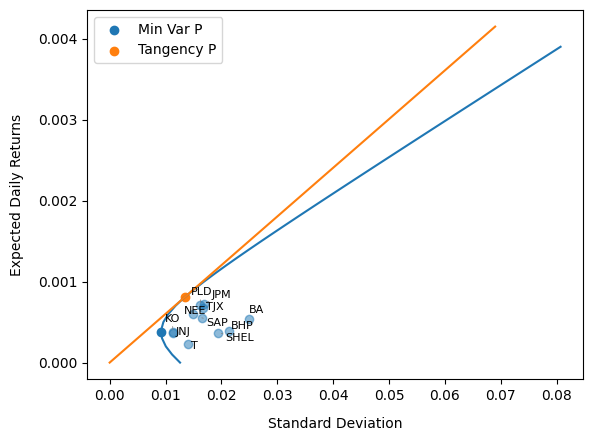

In [5]:
#Plot efficent frontier
ans = PORTFOLIOS(returns)

In [6]:
#Get daily returns for optimal portfolio
weights = ans['Optimal']['weights']
rets = pd.DataFrame(np.dot(returns, weights), index=returns.index, columns=['Portfolio'])

In [7]:
#Optimal portfolio weights
weights

array([-0.13989252, -0.08698501,  0.12787994,  0.46037561, -0.01653903,
        0.33277118,  0.24723709,  0.1300969 , -0.05753167, -0.26224675,
        0.26483426])

In [8]:
#Combine the two dataframes
returns['Portfolio'] = rets

In [9]:
returns.tail()

Ticker,BA,BHP,JNJ,JPM,KO,NEE,PLD,SAP,SHEL,T,TJX,Portfolio
Date,,,,,,,,,,,,
2024-03-22,0.006127,-0.014683,-0.003339,-0.012258,0.000331,0.006845,-0.009778,0.002772,0.001047,-0.010490,0.003025,-0.001943
2024-03-25,0.013556,-0.001403,-0.000064,-0.009155,-0.001488,0.013435,-0.011584,-0.000358,0.007472,0.008245,-0.013068,-0.010466
2024-03-26,-0.020427,-0.007198,0.003543,0.004671,0.002318,-0.018847,-0.015653,0.007067,-0.009789,0.003505,0.011408,-0.000508
2024-03-27,0.023733,0.017330,0.014059,0.019363,0.008094,0.038418,0.029727,0.002186,0.000000,0.021537,0.017925,0.025269
2024-03-28,0.005418,0.002781,0.001456,0.003909,0.002458,0.001881,0.010554,-0.010452,0.004194,0.002849,0.003364,0.002723


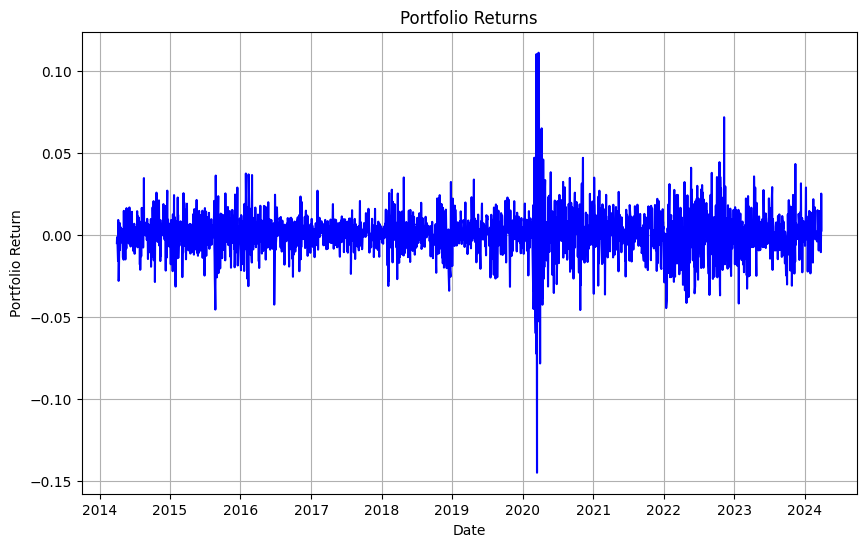

In [10]:
# Plot the portfolio returns
plt.figure(figsize=(10, 6))
plt.plot(returns.index, returns['Portfolio'], linestyle='-', color='b')
plt.title('Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Portfolio Return')
plt.grid(True)
plt.show()

In [11]:
#Calculate the cumulative sum for each stock
cumulative_returns = returns.cumsum()

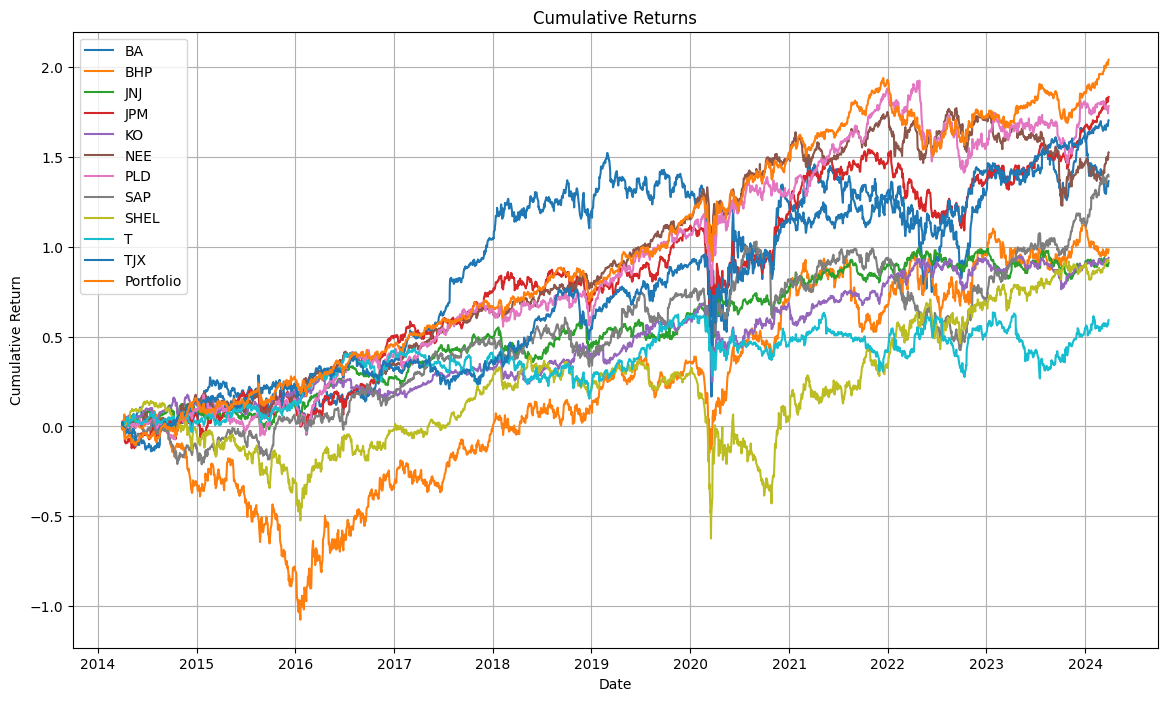

In [12]:
#Plot the cumulative returns for all stocks
plt.figure(figsize=(14, 8))
for column in cumulative_returns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=column)

plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

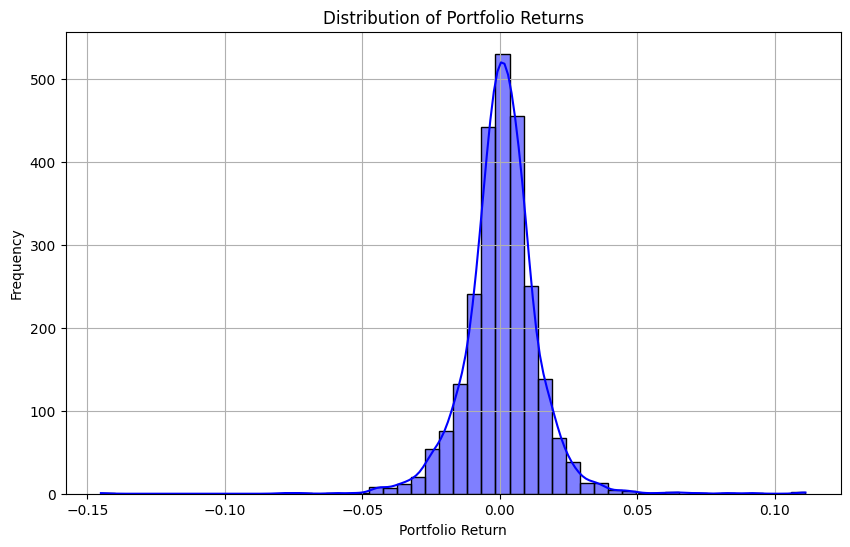

In [13]:
#Plot histogram of the average returns with a KDE line
plt.figure(figsize=(10, 6))
sns.histplot(returns['Portfolio'], kde=True, bins=50, color='blue')
plt.title('Distribution of Portfolio Returns')
plt.xlabel('Portfolio Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [14]:
#VaR using Historic Simulation
def portfolio_VaR_nonparametric(portfolio_returns, value=1000, p = 0.01):
    
    HS_Var = -np.percentile(portfolio_returns, 100 * p) * value
    return HS_Var

In [15]:
#Calclulate HS VaR
portfolio_VaR_nonparametric(rets)

35.545000544548635

In [16]:
#ES for historic simulation
def portfolio_ES(portfolio_returns, value=1000, p = 0.01):
    
    #Calculate the VaR using historical simulation
    var_percentage = np.percentile(portfolio_returns, 100 * p)
    
    #Calculate the indices of returns below the VaR threshold
    below_var_indices = np.where(portfolio_returns <= var_percentage)[0]
    
    #Calculate the Expected Shortfall
    es = -np.mean(portfolio_returns[below_var_indices])
    
    es_monetary = es * value
    
    return es_monetary

In [17]:
#Expected shortfall for portfolio
portfolio_ES(rets['Portfolio'])

48.40787592588715

In [18]:
#Parametric VaR assuming normal distribution
def portfolio_VaR_parametric(portfolio_returns, value=1000, p=0.01):
    
    std_return = np.std(portfolio_returns, ddof=1)
    
    #Calculate the z-score corresponding to the confidence level
    z_score = norm.ppf(1 - p)
    
    #Calculate the VaR as a percentage of the portfolio value
    var_percentage = z_score * std_return
    
    var = value * var_percentage
    return var

In [19]:
#VaR for portfolio assuming normal distribution
portfolio_VaR_parametric(rets['Portfolio'])

31.35249960995884

In [20]:
#ES given normal distribution VaR
def norm_ES(portfolio_returns, value=1000, p=0.01):
    std_return = np.std(portfolio_returns, ddof=1)
    
    #Calculate the z-score
    z_score = norm.ppf(1 - p)
    
    ES = 1/p * norm.pdf(z_score) * std_return
    
    return ES * value

In [21]:
#Portfolio ES assuming normal distribution
norm_ES(rets['Portfolio'])

35.91944641482357

In [22]:
#Calculate VaR assuming t-distribution
def t_dist_VaR(returns, p=0.01, value=1000):
    
    #scale the returns
    scy1 = returns * 100
    res = stats.t.fit(scy1)

    # rescale volatility
    sigma = res[2]/100
    nu = res[0]

    VaR = -sigma*stats.t.ppf(p,nu)*value
    
    return VaR

In [23]:
#Portfolio VaR assuming t-distribution
t_dist_VaR(rets['Portfolio'])

36.549162393271324

In [24]:
#Calculate ES assuming t-distribution
def ES_T_dist(portfolio_returns, p=0.01, value=1000):
    from scipy.special import gamma
    
    #Calculate the mean, standard deviation and dof of the series
    mu = portfolio_returns.mean()
    sigma = portfolio_returns.std(ddof=1)
    res = stats.t.fit(portfolio_returns)
    dof = res[0]
    
    #Calculate the quantile and density for the given probability and degrees of freedom
    t_inv = t.ppf(p, dof)
    scaled_t_inv = np.sqrt((dof - 2) / dof) * t_inv
    
    #f_v(q_v(alpha)) calculation
    f_v_q_alpha = (np.pi * (dof - 2))**(-0.5) * (gamma(dof/2))**(-1) * gamma((dof+1)/2) * (1 + ((dof - 2)**(-1)) * (scaled_t_inv)**2)**((-(1+dof)/2))
    
    #Calculate ES
    es = (-mu) + (1 / (p * (dof - 1))) * (dof - 2 + t_inv**2) * f_v_q_alpha * sigma * value
    
    return es

In [25]:
#Portfolio ES assuming t-distribution
ES_T_dist(rets['Portfolio'])

116.26161826687148

In [26]:
#Calclulate age weighted VaR
def BRW_VaR(returns, value=1000, lamb=0.99, p=0.01):
    '''
    lamb value between 0-1, indicates the bias for more recent observations. Lower lamb means more bias to recent observations
    '''
    
    #Check if input is a pd.Series and convert to dataframe
    if isinstance(returns, pd.Series):
        rets = returns.to_frame()
    else:
        print('Returns are not a series')
    
    #Rename column
    rets.rename(columns={rets.columns[0] : 'Close'}, inplace=True)
    
    #Sort and assign recency rank
    rets = rets.sort_values(by='Date', ascending=False)
    rets['Recency_rank'] = range(1, len(rets) + 1)
    
    #Add Weight vector
    rets.sort_values(by='Close', inplace=True)
    rets['W_Factor'] = rets['Recency_rank'].apply(lambda x: lamb**x)
    
    total = rets['W_Factor'].sum()
    
    #Adjust weight factor
    rets['Adjust'] = rets['W_Factor'].apply(lambda x: x/total)
    
    rets['Cumulative'] = rets['Adjust'].cumsum()
    
    
    rets['Diff'] = (rets['Cumulative'] - p).abs()
    min_index = rets['Diff'].idxmin()
    closest_value = rets.loc[min_index, 'Close']
    
    return closest_value * -value

In [27]:
#Set different values for lambda
lam_values = [0.99, 0.97, 0.94, 0.9]

#Portfolio age weighted VaR 
for i in lam_values:
    x = BRW_VaR(rets['Portfolio'], lamb=i)
    print(f"Lambda: {i}, VaR: {x}")

Lambda: 0.99, VaR: 25.525077768049087
Lambda: 0.97, VaR: 23.412832662575095
Lambda: 0.94, VaR: 16.958000007409435
Lambda: 0.9, VaR: 10.4825349600107


In [28]:
#Modified VaR calculation
def Modified_VaR(returns, value=1000, p=0.01):
    import scipy.stats as ss
    
    mean = returns.mean()
    std = np.std(returns, ddof=1)
    skew = ss.skew(returns)
    kurt = ss.kurtosis(returns, fisher=False)
    b = norm.ppf(p) + (1/6) * (norm.ppf(p)**2 - 1) * skew
    c = (1/24) * (norm.ppf(p)**3 - 3 * norm.ppf(p)) * kurt
    d = (1/36) * (2 * norm.ppf(p)**3 - 5 * norm.ppf(p)) * skew**2
    
    return -(mean + std * (b + c + d)) * value

In [29]:
#Portfolio modified VaR
Modified_VaR(rets)

Portfolio    78.675565
dtype: float64

In [30]:
#Rolling window backtesting for VaR
def Backtesting(returns, WE, p=0.01, func=None, lamb=None, f_name=None):

    #Set variabels
    T = len(returns)
    value = 1
    
    #Initialize new array to store a series of rolling window results
    VaR = np.full([T,1], np.nan)
    
    #Rolling window calculation
    for t in range(WE, T):
        t1 = t - WE
        t2 = t - 1       
        window = returns[t1:t2+1]
        if func != BRW_VaR:
            VaR[t,0] = func(window, value=-value, p=p)
        else:
            VaR[t,0] = func(window, value=-value, p=p, lamb=lamb)
    
    #Turn out-of-sample VaR results into 1 dimension
    VaR = VaR.flatten()
    
    #Ratio of times returns exceeded VaR
    VR = sum(returns[WE:T] > -VaR[WE:T])/(p*(T-WE))
    s = np.std(VaR[WE:T], ddof=1)
    print (f"{f_name} \n", "Violation ratio:", round(VR, 4), "\n", "Volatility:", round(s, 4), "\n")
            
    VaR = pd.Series(VaR)
            
    returns = returns.to_frame()
    name = returns.columns[0]
    returns.reset_index(inplace=True)
    
    #Plot rolling window results
    plt.plot(returns[name][WE:T])
    plt.plot(VaR[WE:T])
    plt.title(f"{f_name} Backtesting")
    plt.show()
    plt.close()
    
    #Create series of VaR results for out-of-sample period
    VaRa = VaR[WE:T]
    
    #Create series of returns exceeding VaR, 1 == exceedance, 0 == not exceeded 
    q = returns[name][WE:T] > -VaR[WE:T]
    v = VaRa*0
    v[q] = 1
    
    #Run statistical tests for unconditional coverage, independance and qudratic probability score (QPS)
    ber = bern_test(p, v[:])
    ind = ind_test(v[:], WE, T)
    qps = QPS(p, v, WE)
    
    print (f"{f_name} \n",
        "Bernoulli:", "Test statistic =", round(ber, 3), "p-value =", round(1 - stats.chi2.cdf(ber, 1), 3), "\n",
        "Independence:", "Test statistic =", round(ind, 3), "p-value =", round(1 - stats.chi2.cdf(ind, 1), 3), "\n",
        "QPS Score: ", qps)
        
    return

#Define Bernoulli test for unconditional coverage
def bern_test(p,v):
    lv = len(v)
    sv = sum(v)
    
    al = np.log(p)*sv + np.log(1-p)*(lv-sv)
    bl = np.log(sv/lv)*sv + np.log(1-sv/lv)*(lv-sv)
    
    return (-2*(al-bl))

#Define test for independance
def ind_test(V, W1, T):
    J = np.full([T,4], 0)
    for i in range(W1+1, W1+len(V)-1):
        J[i,0] = (V[i-1] == 0) & (V[i] == 0)
        J[i,1] = (V[i-1] == 0) & (V[i] == 1)
        J[i,2] = (V[i-1] == 1) & (V[i] == 0)
        J[i,3] = (V[i-1] == 1) & (V[i] == 1)

    V_00 = sum(J[:,0])
    V_01 = sum(J[:,1])
    V_10 = sum(J[:,2])
    V_11 = sum(J[:,3])
    
    p_00=V_00/(V_00+V_01)
    p_01=V_01/(V_00+V_01)
    p_10=V_10/(V_10+V_11)
    p_11=V_11/(V_10+V_11)
    
    hat_p = (V_01+V_11)/(V_00+V_01+V_10+V_11)
    al = np.log(1-hat_p)*(V_00+V_10) + np.log(hat_p)*(V_01+V_11)
    bl = np.log(p_00)*V_00 + np.log(p_01)*V_01 + np.log(p_10)*V_10 + np.log(p_11)*V_11
    
    return (-2*(al-bl))

#Define qudratic probability score to compare different backtesting models
def QPS(p,v, WE):
    lv = len(v)
    sv = sum(v)
    c = ceil(p*lv)
    pv = c/lv
    
    v_ans = sum((v - pv)**2) * 2 / lv
    
    return v_ans
        

Historic Simulation 
 Violation ratio: 1.3889 
 Volatility: 0.009 



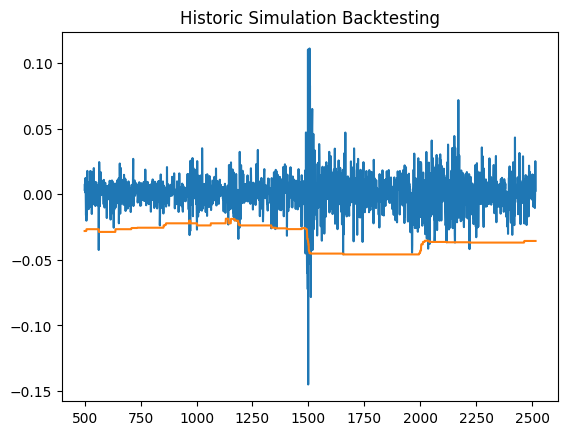

Historic Simulation 
 Bernoulli: Test statistic = 2.747 p-value = 0.097 
 Independence: Test statistic = 0.693 p-value = 0.405 
 QPS Score:  0.027416087962961487


In [31]:
#Backtest Historic Simulation VaR with 500 observation sample period
Backtesting(rets['Portfolio'], WE=500, func=portfolio_VaR_nonparametric, f_name='Historic Simulation')

VaR Normal Distribution 
 Violation ratio: 1.9345 
 Volatility: 0.0096 



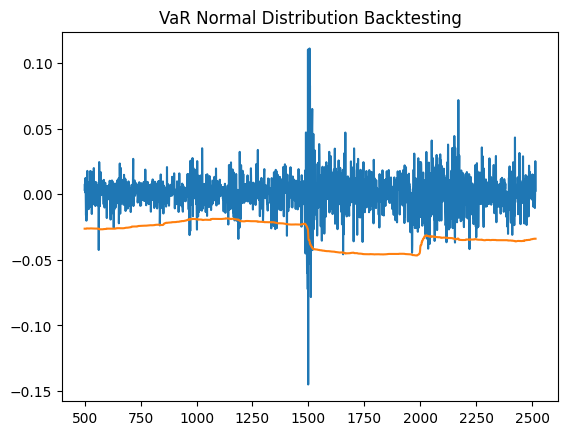

VaR Normal Distribution 
 Bernoulli: Test statistic = 13.968 p-value = 0.0 
 Independence: Test statistic = 0.075 p-value = 0.784 
 QPS Score:  0.03810143849206186


In [32]:
#Backtest normal distribution VaR with 500 observation sample period
Backtesting(rets['Portfolio'], WE=500, func=portfolio_VaR_parametric, f_name='VaR Normal Distribution')

VaR T-Distribution 
 Violation ratio: 1.2897 
 Volatility: 0.0132 



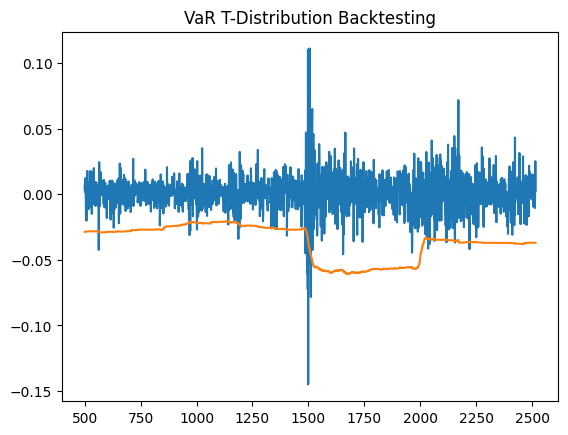

VaR T-Distribution 
 Bernoulli: Test statistic = 1.566 p-value = 0.211 
 Independence: Test statistic = 0.89 p-value = 0.346 
 QPS Score:  0.02547329695767049


In [33]:
#Backtest t-distribution VaR with 500 observation sample period
Backtesting(rets['Portfolio'], WE=500, func=t_dist_VaR, f_name='VaR T-Distribution')

Age weighted VaR 
 Violation ratio: 1.1409 
 Volatility: 0.0219 



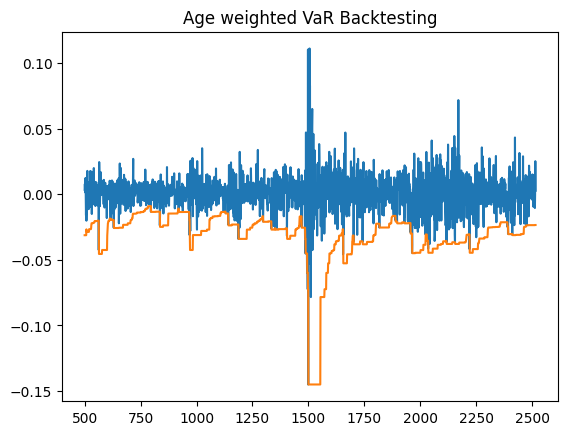

Age weighted VaR 
 Bernoulli: Test statistic = 0.387 p-value = 0.534 
 Independence: Test statistic = nan p-value = nan 
 QPS Score:  0.02255911044973516


/var/folders/rm/zw5ycl5x75vd7k4_ycrpc8780000gn/T/ipykernel_61493/3322544698.py:93: RuntimeWarning: divide by zero encountered in log
  bl = np.log(p_00)*V_00 + np.log(p_01)*V_01 + np.log(p_10)*V_10 + np.log(p_11)*V_11
/var/folders/rm/zw5ycl5x75vd7k4_ycrpc8780000gn/T/ipykernel_61493/3322544698.py:93: RuntimeWarning: invalid value encountered in scalar multiply
  bl = np.log(p_00)*V_00 + np.log(p_01)*V_01 + np.log(p_10)*V_10 + np.log(p_11)*V_11


In [34]:
#Backtest age weighted VaR with 500 observation sample period and lambda == 0.97
Backtesting(rets['Portfolio'], WE=500, func=BRW_VaR, lamb=0.97, f_name='Age weighted VaR')

Modified VaR 
 Violation ratio: 0.3472 
 Volatility: 0.0347 



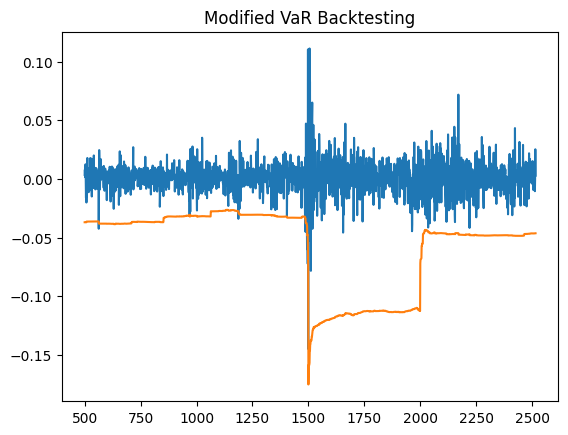

Modified VaR 
 Bernoulli: Test statistic = 11.598 p-value = 0.001 
 Independence: Test statistic = nan p-value = nan 
 QPS Score:  0.007016782407407661


/var/folders/rm/zw5ycl5x75vd7k4_ycrpc8780000gn/T/ipykernel_61493/3322544698.py:93: RuntimeWarning: divide by zero encountered in log
  bl = np.log(p_00)*V_00 + np.log(p_01)*V_01 + np.log(p_10)*V_10 + np.log(p_11)*V_11
/var/folders/rm/zw5ycl5x75vd7k4_ycrpc8780000gn/T/ipykernel_61493/3322544698.py:93: RuntimeWarning: invalid value encountered in scalar multiply
  bl = np.log(p_00)*V_00 + np.log(p_01)*V_01 + np.log(p_10)*V_10 + np.log(p_11)*V_11


In [35]:
#Backtest Modified VaR with 500 observation sample period
Backtesting(rets['Portfolio'], WE=500, func=Modified_VaR, f_name='Modified VaR')